In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import lightgbm as lgb

# display for this notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
dfoff = pd.read_csv(r'E:\TIANCHI\O2O\ccf_offline_stage1_train.csv',keep_default_na=False)
dftest = pd.read_csv(r'E:\TIANCHI\O2O\ccf_offline_stage1_test_revised.csv',keep_default_na=False)
dfon = pd.read_csv(r'E:\TIANCHI\O2O\ccf_online_stage1_train.csv',keep_default_na=False)
dfoff.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null


In [5]:
dfoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        object
Discount_rate    object
Distance         object
Date_received    object
Date             object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [6]:
dfoff.count()

User_id          1754884
Merchant_id      1754884
Coupon_id        1754884
Discount_rate    1754884
Distance         1754884
Date_received    1754884
Date             1754884
dtype: int64

In [7]:
dfoff['Coupon_id'].isnull().value_counts()

False    1754884
Name: Coupon_id, dtype: int64

In [9]:
print('领取优惠券但没有使用',dfoff[(dfoff['Date']=='null') & (dfoff['Coupon_id']!='null')].shape[0])
print('普通消费',dfoff[(dfoff['Date']!='null') & (dfoff['Coupon_id']=='null')].shape[0])
print('领取优惠券并且使用:',dfoff[(dfoff['Date']!='null') & (dfoff['Coupon_id']!='null')].shape[0])

领取优惠券但没有使用 977900
普通消费 701602
领取优惠券并且使用: 75382


In [10]:
 print('仅出现在测试集中的用户：',set(dftest['User_id']) -set(dfoff['User_id']))

仅出现在测试集中的用户： {2495873, 1286474}


In [11]:
print('进出现在测试集中的商户:',set(dftest['Merchant_id'])-set(dfoff['Merchant_id']))

进出现在测试集中的商户: {5920}


## Note
 - 977900人领取优惠券但是未使用，701602人消费时没有领取优惠券，只有75382人使用优惠券进行消费
 - 线下的test集中有两名新用户，有一家新的商户。
 ---

## 优惠券和距离

In [12]:
print('Discount_rate类型：',dfoff['Discount_rate'].unique())

Discount_rate类型： ['null' '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']


In [79]:
dfoff['Discount_rate'].head()

0      null
1    150:20
2      20:1
3      20:1
4      20:1
Name: Discount_rate, dtype: object

In [13]:
print('Distance类型：',dfoff['Distance'].unique())

Distance类型： ['0' '1' 'null' '2' '10' '4' '7' '9' '3' '5' '6' '8']


In [14]:
dfoff['Distance'].dtypes

dtype('O')

 - 将满xx元减yy类型的券变成折扣率。1-yy/xx
 - 同时建立折扣券的相关特征discount_rate,discount_man,discount_jian,discount_type

In [15]:
def getDiscountType(row):
    if row=='null':
        return 'null'
    elif ':' in row:
        return 1
    else :
        return 0
def convertRate(row):
    if row=='null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0-float(rows[1])/float(rows[0])
    else :
        return float(row)
def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else :
        return 0
def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
def processData(df):
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    print(df['discount_rate'].unique())
    
    df['distance'] = df['Distance'].replace('null',-1).astype(int)
    print(df['distance'].unique())
    return df

In [16]:
dfoff = processData(dfoff)
dftest = processData(dftest)

[1.         0.86666667 0.95       0.9        0.83333333 0.8
 0.5        0.85       0.75       0.66666667 0.93333333 0.7
 0.6        0.96666667 0.98       0.99       0.975      0.33333333
 0.2        0.4       ]
[ 0  1 -1  2 10  4  7  9  3  5  6  8]
[0.83333333 0.9        0.96666667 0.8        0.95       0.75
 0.98       0.5        0.86666667 0.6        0.66666667 0.7
 0.85       0.33333333 0.94       0.93333333 0.975      0.99      ]
[ 1 -1  5  2  0 10  3  6  7  4  9  8]


In [17]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,discount_type,distance
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,null,0
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,1,1


In [18]:
dftest.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_man,discount_jian,discount_type,distance
0,4129537,450,9983,30:05:00,1,20160712,0.833333,30,5,1,1
1,6949378,1300,3429,30:05:00,null,20160706,0.833333,30,5,1,-1


In [19]:
date_received = dfoff['Date_received'].unique()
date_received = sorted(date_received[date_received!='null'])

date_buy = dfoff['Date'].unique()
date_buy = sorted(date_buy[date_buy!='null'])

date_buy = sorted(dfoff[dfoff['Date']!='null']['Date'])
print('优惠券收到日期从',date_received[0],'到',date_received[-1])
print('消费日期从',date_buy[0],'到',date_buy[-1])

优惠券收到日期从 20160101 到 20160615
消费日期从 20160101 到 20160630


每天客户收到的Coupon数目，以及收到coupon之后使用的数目。

In [22]:
couponbydate = dfoff[dfoff['Date_received'] != 'null'][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
couponbydate.columns = ['Date_received','count']
buybydate = dfoff[(dfoff['Date'] != 'null') & (dfoff['Date_received'] != 'null')][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
buybydate.columns = ['Date_received','count']

In [23]:
type(date_received)

list

D:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


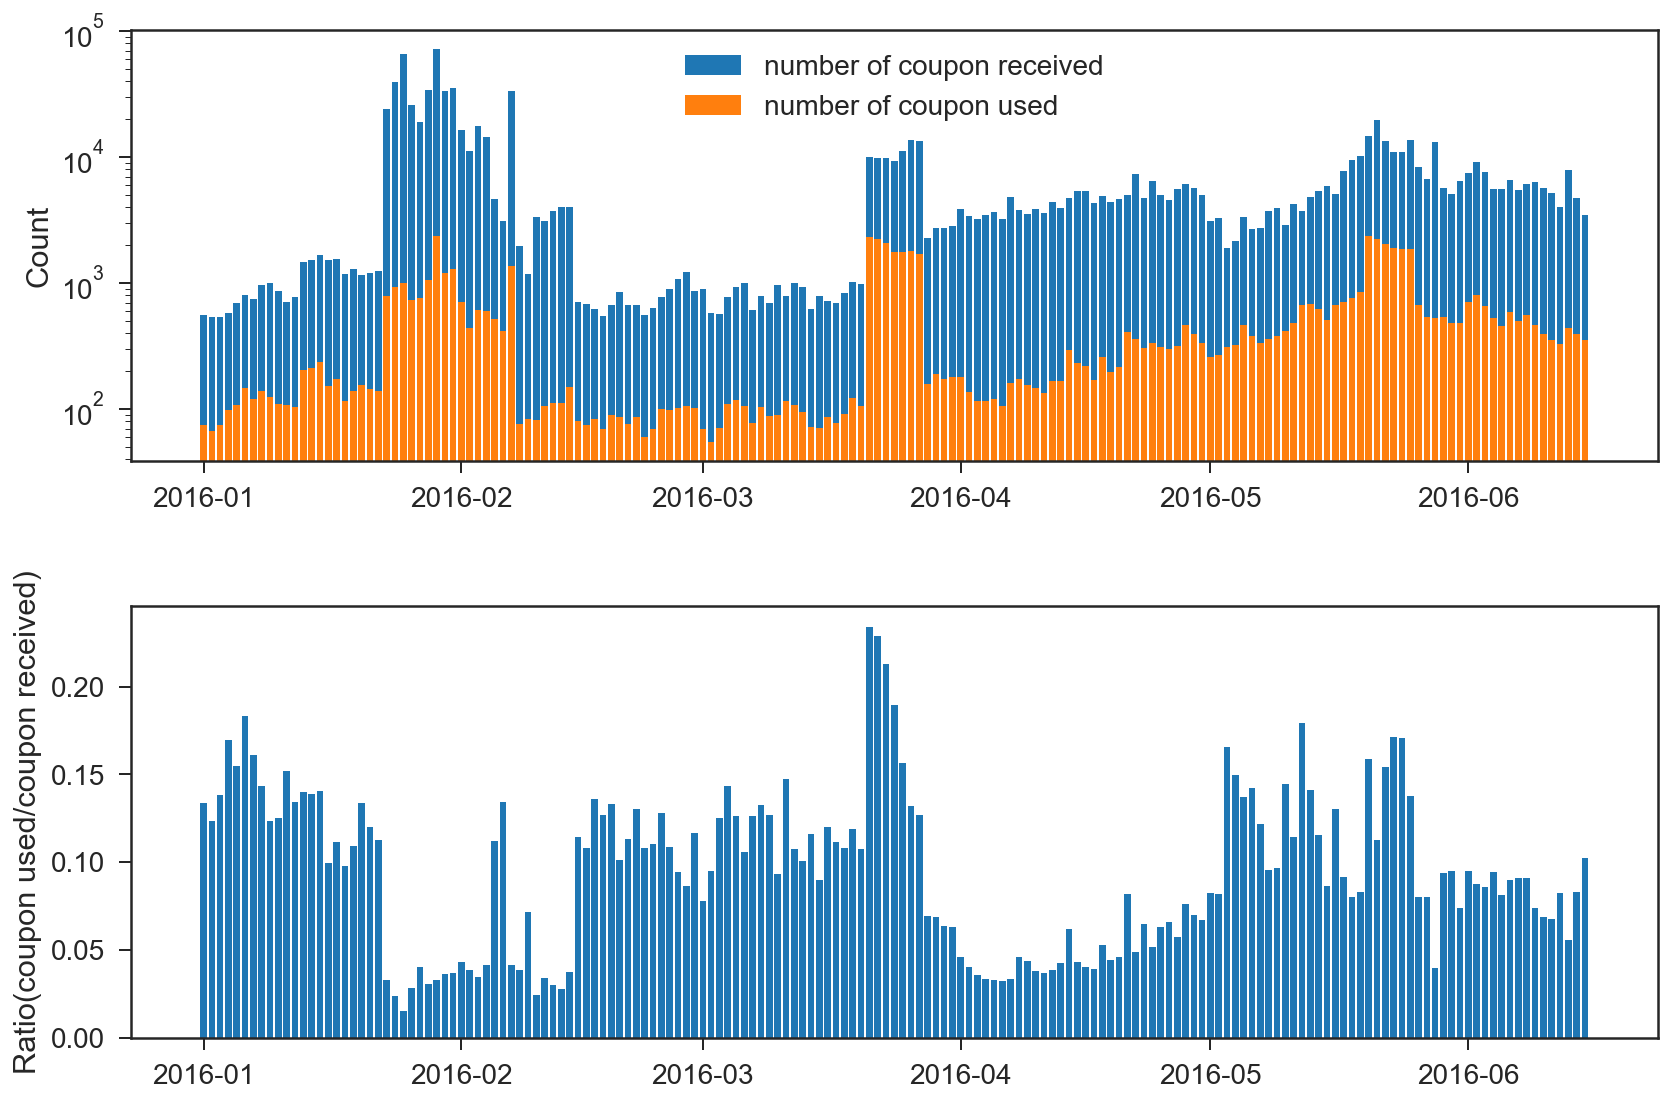

In [23]:
sns.set_style('ticks')
sns.set_context("notebook", font_scale= 1.4)
plt.figure(figsize = (12,8))
date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')

plt.subplot(211)
plt.bar(date_received_dt, couponbydate['count'], label = 'number of coupon received' )
plt.bar(date_received_dt, buybydate['count'], label = 'number of coupon used')
plt.yscale('log')
plt.ylabel('Count')
plt.legend()

plt.subplot(212)
plt.bar(date_received_dt, buybydate['count']/couponbydate['count'])
plt.ylabel('Ratio(coupon used/coupon received)')
plt.tight_layout()#调整子图间隔减少堆叠

In [24]:
def getWeekday(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

dfoff['weekday'] = dfoff['Date_received'].astype(str).apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].astype(str).apply(getWeekday)

# weekday_type :  周六和周日为1，其他为0
dfoff['weekday_type'] = dfoff['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
dftest['weekday_type'] = dftest['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )

In [25]:
# change weekday to one-hot encoding 
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace('null', np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace('null', np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


## 数据标注

 - Date_received == 'null': y = -1
 - Date != 'null' & Date-Date_received <= 15: y = 1
 - Otherwise: y = 0

In [26]:
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0
dfoff['label'] = dfoff.apply(label, axis = 1)

In [27]:
print(dfoff['label'].value_counts())

 0    988887
-1    701602
 1     64395
Name: label, dtype: int64


In [28]:
print('已有columns：',dfoff.columns.tolist())

已有columns： ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date', 'discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'label']


In [29]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,...,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,...,null,0,0,0,0,0,0,0,0,-1
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,...,6,1,0,0,0,0,0,1,0,0


 - 直接用 discount, distance, weekday 类的特征。
 - train/valid 的划分：用20160101到20160515的作为train，20160516到20160615作为valid。 
 - 用线性模型 SGDClassifier

In [31]:
# data split
df = dfoff[dfoff['label'] != -1].copy()
train = df[(df['Date_received'] < '20160516')].copy()
valid = df[(df['Date_received'] >= '20160516') & (df['Date_received'] <= '20160615')].copy()
print(train['label'].value_counts())
print(valid['label'].value_counts())

0    759172
1     41524
Name: label, dtype: int64
0    229715
1     22871
Name: label, dtype: int64


In [32]:
# feature
original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','distance', 'weekday', 'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [ ]:
# model1
import os
import pickle
predictors = original_feature
print(predictors)

def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

In [37]:
if not os.path.isfile('1_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('1_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('1_model.pkl', 'rb') as f:
        model = pickle.load(f)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.6min finished
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
 

0.9481401180972554
{'en__alpha': 0.001, 'en__l1_ratio': 0.001}


In [38]:
# valid predict
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
valid1.head(2)

D:\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,...,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label,pred_prob
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,...,1,0,0,0,0,0,1,0,0,0.019597
4,1439408,2632,8591,20:1,0,20160613,null,0.950000,20,1,...,0,1,0,0,0,0,0,0,0,0.100638


In [39]:
# avgAUC calculation
vg = valid1.groupby(['Coupon_id'])
aucs = []
for i in vg:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

0.5323444694516164


In [40]:
# test prediction for submission
y_test_pred = model.predict_proba(dftest[predictors])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('submit1.csv', index=False, header=False)
dftest1.head()

D:\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.104737
1,6949378,3429,20160706,0.152925
2,2166529,6928,20160727,0.005499
3,2166529,1808,20160727,0.018629
4,6172162,6500,20160708,0.063540


In [41]:
feature = dfoff[(dfoff['Date'] < '20160516') | ((dfoff['Date'] == 'null') & (dfoff['Date_received'] < '20160516'))].copy()
data = dfoff[(dfoff['Date_received'] >= '20160516') & (dfoff['Date_received'] <= '20160615')].copy()
print(data['label'].value_counts())

0    229715
1     22871
Name: label, dtype: int64


In [42]:
fdf = feature.copy()

In [43]:
# key of user
u = fdf[['User_id']].copy().drop_duplicates()

In [44]:
# u_coupon_count : num of coupon received by user
u1 = fdf[fdf['Date_received'] != 'null'][['User_id']].copy()
u1['u_coupon_count'] = 1
u1 = u1.groupby(['User_id'], as_index = False).count()
u1.head(2)

,User_id,u_coupon_count
0,4,1
1,35,4


In [45]:
# u_buy_count : times of user buy offline (with or without coupon)
u2 = fdf[fdf['Date'] != 'null'][['User_id']].copy()
u2['u_buy_count'] = 1
u2 = u2.groupby(['User_id'], as_index = False).count()
u2.head(2)

,User_id,u_buy_count
0,165,10
1,184,1


In [46]:
# u_buy_with_coupon : times of user buy offline (with coupon)
u3 = fdf[((fdf['Date'] != 'null') & (fdf['Date_received'] != 'null'))][['User_id']].copy()
u3['u_buy_with_coupon'] = 1
u3 = u3.groupby(['User_id'], as_index = False).count()
u3.head(2)

,User_id,u_buy_with_coupon
0,184,1
1,417,1


In [47]:
# u_merchant_count : num of merchant user bought from
u4 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
u4.drop_duplicates(inplace = True)
u4 = u4.groupby(['User_id'], as_index = False).count()
u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)
u4.head(2)

,User_id,u_merchant_count
0,165,2
1,184,1


In [48]:
# u_min_distance
utmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['User_id', 'distance']].copy()
utmp.replace(-1, np.nan, inplace = True)
u5 = utmp.groupby(['User_id'], as_index = False).min()
u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
u6 = utmp.groupby(['User_id'], as_index = False).max()
u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
u7 = utmp.groupby(['User_id'], as_index = False).mean()
u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
u8 = utmp.groupby(['User_id'], as_index = False).median()
u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)
u8.head(2)

,User_id,u_median_distance
0,184,0.0
1,417,0.0


In [49]:
u.shape, u1.shape, u2.shape, u3.shape, u4.shape, u5.shape, u6.shape, u7.shape, u8.shape

((453684, 1),
 (412635, 2),
 (173770, 2),
 (29594, 2),
 (173770, 2),
 (29594, 2),
 (29594, 2),
 (29594, 2),
 (29594, 2))

In [50]:
# merge all the features on key User_id
user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')

In [51]:
# calculate rate

user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
user_feature = user_feature.fillna(0)
user_feature.head(2)


,User_id,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate
0,1439408,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# add user feature to data on key User_id
data2 = pd.merge(data, user_feature, on = 'User_id', how = 'left').fillna(0)

# split data2 into valid and train
train, valid = train_test_split(data2, test_size = 0.2, stratify = data2['label'], random_state=100)

In [53]:
# model2
predictors = original_feature + user_feature.columns.tolist()[1:]
print(len(predictors), predictors)

if not os.path.isfile('2_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('2_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('2_model.pkl', 'rb') as f:
        model = pickle.load(f)

24 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   47.0s finished
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9105103232575172
{'en__alpha': 0.001, 'en__l1_ratio': 0.001}


In [54]:
# valid set performance 
valid['pred_prob'] = model.predict_proba(valid[predictors])[:,1]
validgroup = valid.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    
    aucs.append(auc(fpr, tpr))
    #aucs.append(roc_auc_score(tmpdf['label'], tmpdf['pred_prob']))
print(np.average(aucs))

D:\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.5993733080284953


In [55]:
# key of merchant
m = fdf[['Merchant_id']].copy().drop_duplicates()

In [56]:
# m_coupon_count : num of coupon from merchant
m1 = fdf[fdf['Date_received'] != 'null'][['Merchant_id']].copy()
m1['m_coupon_count'] = 1
m1 = m1.groupby(['Merchant_id'], as_index = False).count()
m1.head(2)

,Merchant_id,m_coupon_count
0,2,1
1,5,5


In [57]:
# m_sale_count : num of sale from merchant (with or without coupon)
m2 = fdf[fdf['Date'] != 'null'][['Merchant_id']].copy()
m2['m_sale_count'] = 1
m2 = m2.groupby(['Merchant_id'], as_index = False).count()
m2.head(2)

,Merchant_id,m_sale_count
0,1,5
1,3,8


In [58]:
# m_sale_with_coupon : num of sale from merchant with coupon usage
m3 = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id']].copy()
m3['m_sale_with_coupon'] = 1
m3 = m3.groupby(['Merchant_id'], as_index = False).count()
m3.head(2)

,Merchant_id,m_sale_with_coupon
0,13,1
1,14,1


In [59]:
# m_min_distance
mtmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
mtmp.replace(-1, np.nan, inplace = True)
m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)
m7.head(2)

,Merchant_id,m_median_distance
0,13,0.0
1,14,0.0


In [60]:
m.shape, m1.shape, m2.shape, m3.shape, m4.shape, m5.shape, m6.shape, m7.shape

((7667, 1),
 (4196, 2),
 (7529, 2),
 (2253, 2),
 (2253, 2),
 (2253, 2),
 (2253, 2),
 (2253, 2))

In [61]:
merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')
merchant_feature = merchant_feature.fillna(0)
merchant_feature.head(5)

,Merchant_id,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance
0,2632,35.0,18.0,3.0,1.0,1.0,1.000000,1.0
1,3381,122834.0,18080.0,2487.0,0.0,10.0,1.652429,1.0
2,2099,16824.0,7227.0,1705.0,0.0,10.0,0.968072,0.0
3,1569,33492.0,896.0,135.0,0.0,10.0,2.260163,1.0
4,4833,8321.0,636.0,116.0,0.0,10.0,3.037736,2.0


In [62]:
merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
merchant_feature = merchant_feature.fillna(0)
merchant_feature.head(2)


,Merchant_id,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate
0,2632,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085714,0.166667
1,3381,122834.0,18080.0,2487.0,0.0,10.0,1.652429,1.0,0.020247,0.137555


In [63]:
# add merchant feature to data2
data3 = pd.merge(data2, merchant_feature, on = 'Merchant_id', how = 'left').fillna(0)

# split data3 into train/valid
train, valid = train_test_split(data3, test_size = 0.2, stratify = data3['label'], random_state=100)

In [64]:
# model 3
predictors = original_feature + user_feature.columns.tolist()[1:] + merchant_feature.columns.tolist()[1:]
print(predictors)

if not os.path.isfile('3_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('3_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('3_model.pkl', 'rb') as f:
        model = pickle.load(f)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   50.1s finished
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9110002573391136
{'en__alpha': 0.001, 'en__l1_ratio': 0.1}


In [65]:
valid['pred_prob'] = model.predict_proba(valid[predictors])[:,1]
validgroup = valid.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6000602309200126


In [66]:
def userFeature(df):
    u = df[['User_id']].copy().drop_duplicates()
    
    # u_coupon_count : num of coupon received by user
    u1 = df[df['Date_received'] != 'null'][['User_id']].copy()
    u1['u_coupon_count'] = 1
    u1 = u1.groupby(['User_id'], as_index = False).count()

    # u_buy_count : times of user buy offline (with or without coupon)
    u2 = df[df['Date'] != 'null'][['User_id']].copy()
    u2['u_buy_count'] = 1
    u2 = u2.groupby(['User_id'], as_index = False).count()

    # u_buy_with_coupon : times of user buy offline (with coupon)
    u3 = df[((df['Date'] != 'null') & (df['Date_received'] != 'null'))][['User_id']].copy()
    u3['u_buy_with_coupon'] = 1
    u3 = u3.groupby(['User_id'], as_index = False).count()

    # u_merchant_count : num of merchant user bought from
    u4 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    u4.drop_duplicates(inplace = True)
    u4 = u4.groupby(['User_id'], as_index = False).count()
    u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)

    # u_min_distance
    utmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['User_id', 'distance']].copy()
    utmp.replace(-1, np.nan, inplace = True)
    u5 = utmp.groupby(['User_id'], as_index = False).min()
    u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
    u6 = utmp.groupby(['User_id'], as_index = False).max()
    u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
    u7 = utmp.groupby(['User_id'], as_index = False).mean()
    u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
    u8 = utmp.groupby(['User_id'], as_index = False).median()
    u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)

    user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')

    user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
    user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
    user_feature = user_feature.fillna(0)
    
    print(user_feature.columns.tolist())
    return user_feature

In [67]:
def merchantFeature(df):
    m = df[['Merchant_id']].copy().drop_duplicates()

    # m_coupon_count : num of coupon from merchant
    m1 = df[df['Date_received'] != 'null'][['Merchant_id']].copy()
    m1['m_coupon_count'] = 1
    m1 = m1.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_count : num of sale from merchant (with or without coupon)
    m2 = df[df['Date'] != 'null'][['Merchant_id']].copy()
    m2['m_sale_count'] = 1
    m2 = m2.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_with_coupon : num of sale from merchant with coupon usage
    m3 = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id']].copy()
    m3['m_sale_with_coupon'] = 1
    m3 = m3.groupby(['Merchant_id'], as_index = False).count()

    # m_min_distance
    mtmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
    mtmp.replace(-1, np.nan, inplace = True)
    m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
    m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
    m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
    m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
    m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
    m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
    m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
    m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)

    merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')

    merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
    merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
    merchant_feature = merchant_feature.fillna(0)
    
    print(merchant_feature.columns.tolist())
    return merchant_feature


In [68]:
def usermerchantFeature(df):

    um = df[['User_id', 'Merchant_id']].copy().drop_duplicates()

    um1 = df[['User_id', 'Merchant_id']].copy()
    um1['um_count'] = 1
    um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um2 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    um2['um_buy_count'] = 1
    um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um3 = df[df['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
    um3['um_coupon_count'] = 1
    um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um4 = df[(df['Date_received'] != 'null') & (df['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
    um4['um_buy_with_coupon'] = 1
    um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = user_merchant_feature.fillna(0)

    user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
    user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
    user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
    user_merchant_feature = user_merchant_feature.fillna(0)

    print(user_merchant_feature.columns.tolist())
    return user_merchant_feature


In [69]:
def featureProcess(feature, train, test):
    """
    feature engineering from feature data
    then assign user, merchant, and user_merchant feature for train and test 
    """
    
    user_feature = userFeature(feature)
    merchant_feature = merchantFeature(feature)
    user_merchant_feature = usermerchantFeature(feature)
    
    train = pd.merge(train, user_feature, on = 'User_id', how = 'left')
    train = pd.merge(train, merchant_feature, on = 'Merchant_id', how = 'left')
    train = pd.merge(train, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    train = train.fillna(0)
    
    test = pd.merge(test, user_feature, on = 'User_id', how = 'left')
    test = pd.merge(test, merchant_feature, on = 'Merchant_id', how = 'left')
    test = pd.merge(test, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    test = test.fillna(0)
    
    return train, test

In [70]:
# repeat result above and process dftest data
feature = dfoff[(dfoff['Date'] < '20160516') | ((dfoff['Date'] == 'null') & (dfoff['Date_received'] < '20160516'))].copy()
data = dfoff[(dfoff['Date_received'] >= '20160516') & (dfoff['Date_received'] <= '20160615')].copy()
print(data['label'].value_counts())

# feature engineering
train, test = featureProcess(feature, data, dftest)

0    229715
1     22871
Name: label, dtype: int64
['User_id', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
['Merchant_id', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
['User_id', 'Merchant_id', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [71]:
# features
predictors = ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance',
              'weekday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
              'weekday_7', 'weekday_type', 
              'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 
              'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 
              'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance',
              'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 
              'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
print(len(predictors), predictors)

40 ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance', 'weekday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'weekday_type', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [72]:
trainSub, validSub = train_test_split(train, test_size = 0.2, stratify = train['label'], random_state=100)

In [73]:
# linear model
model = check_model(trainSub, predictors)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   58.9s finished
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [74]:
validSub['pred_prob'] = model.predict_proba(validSub[predictors])[:,1]
validgroup = validSub.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6227851407249453


In [75]:
model = lgb.LGBMClassifier(
                    learning_rate = 0.01,
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    metric = 'logloss',
                    max_depth = 5,
                    sub_feature = 0.7,
                    num_leaves = 3,
                    colsample_bytree = 0.7,
                    n_estimators = 5000,
                    early_stop = 50,
                    verbose = -1)
model.fit(trainSub[predictors], trainSub['label'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        early_stop=50, importance_type='split', learning_rate=0.01,
        max_depth=5, metric='logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=-1, num_leaves=3, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, sub_feature=0.7,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)

In [76]:
validSub['pred_prob'] = model.predict_proba(validSub[predictors])[:,1]
validgroup = validSub.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6315035180062087


In [77]:
# test prediction for submission
y_test_pred = model.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('submit2.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.013701
1,6949378,3429,20160706,0.147059
2,2166529,6928,20160727,0.006868
3,2166529,1808,20160727,0.006674
4,6172162,6500,20160708,0.081664
